# Setup:

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
import cv2
import pandas as pd
from shutil import copyfile
import os
import fnmatch
from skimage import util
import numpy as np
from skimage import transform
from skimage.transform import AffineTransform
from skimage.util import random_noise
from skimage.color import rgb2gray
import math
import os
import random
import keras
import tensorflow as tf
from posixpath import join
from keras.layers import Input
from keras.models import Model
from keras.utils.vis_utils import plot_model
from google.colab.patches import cv2_imshow
from glob import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shutil
import seaborn as sn
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.preprocessing import image
from keras.models import load_model
from google.colab import output

In [4]:
test_nums = set([1,2])

In [5]:
WORKING_DIR = '/content/drive/My Drive/539Project/test/CreatedDataset'
TRAIN_DIR = '/content/drive/My Drive/539Project/test/CreatedDataset/Network/train'
VAL_DIR = '/content/drive/My Drive/539Project/test/CreatedDataset/Network/val'


# Classification Training:

In [6]:
def change_model(model, new_input_shape=(None, 40, 40, 3),custom_objects=None):
    # replace input shape of first layer
    
    config = model.layers[0].get_config()
    config['batch_input_shape']=new_input_shape
    model.layers[0]=model.layers[0].from_config(config)

    # rebuild model architecture by exporting and importing via json
    new_model = tf.keras.models.model_from_json(model.to_json(),custom_objects=custom_objects)

    # copy weights from old model to new one
    for layer in new_model.layers:
        try:
            layer.set_weights(model.get_layer(name=layer.name).get_weights())
            print("Loaded layer {}".format(layer.name))
        except:
            print("Could not transfer weights for layer {}".format(layer.name))

    return new_model

In [7]:

WIDTH = 64
HEIGHT = 64
BATCH_SIZE = 20

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=0,
    zoom_range=[1,2],
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=0,
    zoom_range=[1,2],
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 240 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [8]:
base_model = ResNet50(weights='imagenet', include_top=False)

94781440/94765736 [==============================] - 1s 0us/step


In [9]:
CLASSES = 2
# These layers were removed by setting include_top=false, but we still want them
x = base_model.output                          # The output layer of the googleNet
x = GlobalAveragePooling2D(name='avg_pool')(x) # This layer is used to downsample the features
x = Dropout(0.4)(x)                            # This layer is used to enforce feature redundancy 

# This layer specifies our classifier output
predictions = Dense(CLASSES, activation='softmax')(x)
#
m = Model(inputs=base_model.input, outputs=predictions)
model = change_model(m, new_input_shape=[None] + [64,64,3])
for layer in base_model.layers:
  layer.trainable = False # Set this to True if you want to re-train the entire network.
model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
output.clear()

In [15]:
EPOCHS = 15
BATCH_SIZE = 15
STEPS_PER_EPOCH = 6
VALIDATION_STEPS = 1
MODEL_FILE = os.path.join(WORKING_DIR,'model')

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Epoch 1/15
6/6 [==============================] - 1s 106ms/step - loss: 1.0309 - accuracy: 0.7833 - val_loss: 4770.4409 - val_accuracy: 0.5000
Epoch 2/15
6/6 [==============================] - 1s 87ms/step - loss: 1.8637 - accuracy: 0.7917 - val_loss: 158727.4062 - val_accuracy: 0.5000
Epoch 3/15
6/6 [==============================] - 1s 87ms/step - loss: 0.9572 - accuracy: 0.7000 - val_loss: 8260.6699 - val_accuracy: 0.5500
Epoch 4/15
6/6 [==============================] - 1s 85ms/step - loss: 1.0387 - accuracy: 0.7417 - val_loss: 2182.4414 - val_accuracy: 0.5500
Epoch 5/15
6/6 [==============================] - 1s 91ms/step - loss: 0.5103 - accuracy: 0.7750 - val_loss: 1206.0551 - val_accuracy: 0.4500
Epoch 6/15
6/6 [==============================] - 1s 84ms/step - loss: 0.6178 - accuracy: 0.7667 - val_loss: 305.8423 - val_accuracy: 0.4000
Epoch 7/15
6/6 [==============================] - 1s 93ms/step - loss: 0.3461 - accuracy: 0.8667 - val_loss: 11.2257 - val_accuracy: 0.6000
Epoch 

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

[0.7833333611488342, 0.7916666865348816, 0.699999988079071, 0.7416666746139526, 0.7749999761581421, 0.7666666507720947, 0.8666666746139526, 0.800000011920929, 0.800000011920929, 0.8583333492279053, 0.8500000238418579, 0.8333333134651184, 0.8083333373069763, 0.875, 0.9583333134651184]
[1.0309194326400757, 1.8636517524719238, 0.9571918249130249, 1.0387250185012817, 0.5103424787521362, 0.6177600622177124, 0.34609225392341614, 0.40934357047080994, 0.479336678981781, 0.7605882883071899, 0.6313188672065735, 0.4399864077568054, 1.059125304222107, 0.25154173374176025, 0.16861769556999207]


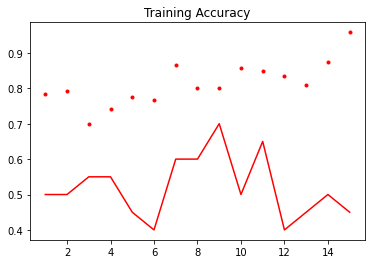

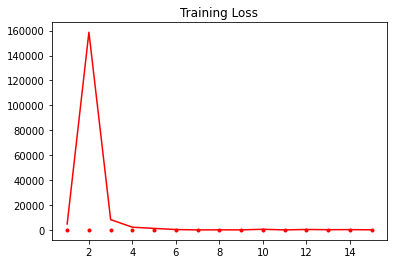

In [17]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)
print(acc)
print(loss)
plt.plot(epochs, val_acc,'r')
plt.plot(epochs, acc,'r.')
plt.title("Training Accuracy")

plt.figure()
plt.plot(epochs, val_loss,'r')
plt.plot(epochs,loss,'r.')
plt.title("Training Loss")
plt.show()

In [18]:
df = pd.DataFrame(acc) 
    
# saving the dataframe 
df.to_csv('acc.csv') 
df = pd.DataFrame(loss) 
    
# saving the dataframe 
df.to_csv('loss.csv') 

# Testing:

In [ ]:
def ComputeSquare(val, total):
    ActuallyNotWaldo = 0
    ActuallyWaldo = 0
    MistakenWaldo = 0
    MistakenNotWaldo = 0
    counter = 0
    decimalpercent = math.ceil(total / 10)
    #Waldo
    file_path = os.path.join(val, 'Waldo')
    for f in os.listdir(file_path):
      x=cv2.imread(os.path.join(file_path, f))
      x = np.expand_dims(x, axis=0)
      preds = model.predict(x)
      if preds[0][1] == 0:
        ActuallyWaldo = ActuallyWaldo + 1
        cv2_imshow(cv2.imread(os.path.join(file_path, f)))
        counter = counter + 1
      else:
        MistakenNotWaldo = MistakenNotWaldo + 1
        counter = counter + 1
      if counter % decimalpercent == 0:
        print(counter / decimalpercent * 10, "% completed with page")
    #Color
    file_path = os.path.join(val, 'Color')
    for f in os.listdir(file_path):
      x=cv2.imread(os.path.join(file_path, f))
      x = np.expand_dims(x, axis=0)
      preds = model.predict(x)
      if preds[0][0] == 0:
        MistakenWaldo = MistakenWaldo + 1
        counter = counter + 1
      else:
        ActuallyNotWaldo = ActuallyNotWaldo + 1
        counter = counter + 1
      if counter % decimalpercent == 0:
        print(counter / decimalpercent * 10, "% completed with page")
    return np.array([[ActuallyWaldo, MistakenWaldo], [MistakenNotWaldo, ActuallyNotWaldo]])

Page  1 :


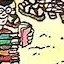

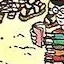

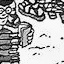

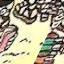

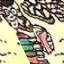

10.0 % completed with page
20.0 % completed with page
30.0 % completed with page
40.0 % completed with page
50.0 % completed with page
60.0 % completed with page
70.0 % completed with page
80.0 % completed with page
90.0 % completed with page
[[   5    0]
 [   0 1333]]
Page  2 :


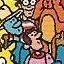

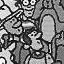

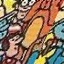

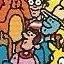

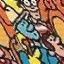

10.0 % completed with page
20.0 % completed with page
30.0 % completed with page
40.0 % completed with page
50.0 % completed with page
60.0 % completed with page
70.0 % completed with page
80.0 % completed with page
90.0 % completed with page
[[  5   0]
 [  0 279]]


In [ ]:
from typing import NewType
result_list = []
for i in range(1, 23):
  if i in test_nums:
    pgPath = os.path.join("/content/drive/"+"My Drive"+"/539Project/test/CreatedDataset" ,
                          'Page' + str(i))
    W = os.listdir(os.path.join(pgPath, 'Waldo'))
    NW = os.listdir(os.path.join(pgPath, 'Color'))
    total = len(fnmatch.filter(W,  '*.jpg')) + len(fnmatch.filter(NW,  '*.jpg')) 
    print("Page ", i, ":")
    results  = ComputeSquare(pgPath, total)
    result_list.append(results)
    print(results)

Text(0.5, 1.0, 'Confusion Matrix')

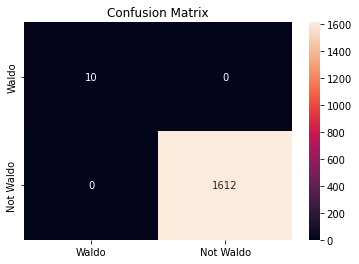

In [ ]:
result_sum = np.array([[0,0],[0,0]])
for result in result_list:
  result_sum += result
result_sum = pd.DataFrame(result_sum, index = ["Waldo","Not Waldo"],columns = ["Waldo","Not Waldo"])
ax = sn.heatmap(result_sum, annot=True,  fmt='g', )
plt.title("Confusion Matrix")

In [ ]:
model.save(MODEL_FILE)

INFO:tensorflow:Assets written to: /content/drive/My Drive/539Project/test/CreatedDataset/model/assets


In [ ]:
drive.flush_and_unmount()